In [23]:
from base import *
from utils import *
from plot_tools import *
import qiskit as qk
from qiskit import QuantumCircuit, Aer, execute
from qiskit.primitives import Estimator
# from qiskit.utils import QuantumInstance
# from qiskit.algorithms import VQE
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, ADAM
from qiskit.opflow import PauliSumOp, AerPauliExpectation
from qiskit.circuit import Parameter
import numpy as np
import seaborn as sns



## The simple hamiltonian
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad \mathcal{E} = \frac{E_1
  + E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
c = (V_{11}+V_{22})/2, 
$$ 
$$
\omega_z = (V_{11}-V_{22})/2, 
$$
$$
\omega_x = V_{12}=V_{21}
$$

In [24]:
# Constants
E_1 = 0
E_2 = 4 
V_11 = 3
V_22 = -3
V_12 = 0.2
V_21 = 0.2
epsilon = (E_1+E_2) / 2
Omega = (E_1-E_2) / 2
c = (V_11 + V_22) / 2
omega_z = (V_11 - V_22) / 2
omega_x = V_12

# Variables
# lmb = 1 # Interaction strength


### Classical numerical solver for the eigenvalues

In [25]:
H_0 = np.array([[E_1, 0],
               [0, E_2]])
H_1 = np.array([[V_11, V_12],
               [V_21, V_22]])


lmbs = np.arange(0, 1, 0.01)
eigs = np.zeros((2, len(lmbs)))

for i, lmb in enumerate(lmbs):
    result = np.linalg.eig(H_0 + lmb * H_1)[0]
    eigs[:,i] = max(result), min(result)

# print(eigs)
# print(lmbs.shape)
plot_2D(lmbs, eigs, plot_count=2, label=[r'$E_0$', r'$E_1$'], title=r'Numerical Eigenvalues for 1 Qubit system vs $\lambda$',
        x_title=r'$\lambda$', y_title=r'Eigenvalues', filename='eigs-1-cl.pdf')



### Quantum Computing 

First we need to rewrite the hamiltonian in terms of Pauli matrices.
$$
H_0 = \mathcal{E} I + \Omega \sigma_z, \quad 
\mathcal{E} = \frac{E_1+ E_2}{2}, \; \Omega = \frac{E_1-E_2}{2},
$$
$$
H_I = c \boldsymbol{I} +\omega_z\sigma_z + \omega_x\sigma_x,
$$
$$
\lambda H_I = \lambda c \boldsymbol{I} + \lambda \omega_z\sigma_z + \lambda \omega_x \sigma_x 
$$
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [26]:
q2 = Qubits_2()

# set up bell state
q2.hadamard(0)
q2.measure(1000)

array([[524.,   0.],
       [  0.,   1.],
       [476.,  10.],
       [  0.,  11.]])

Set up

In [27]:

def H(lmb):
    return PauliSumOp.from_list([('X', lmb*omega_x), 
                                 ('Z', Omega+lmb*omega_z), 
                                 ('I', lmb*c+epsilon)]) # Hamiltonian using operators

def ansatz():
    # creates an ansatz that are functions of the parameters TODO: maybe can be changed to Hartree Fock initial state? 
    # from HartreeFock.construct_circuit()
    theta = Parameter('theta')
    phi = Parameter('phi')
    qc = QuantumCircuit(1)
    qc.rx(theta,0)
    qc.ry(phi,0)
    return qc


def prep_vqe():
    adam = ADAM(maxiter = 10000)
    slsqp = SLSQP(maxiter=10000)
    # backend = Aer.get_backend('qasm_simulator')
    estimator = Estimator()

    vqe = VQE(ansatz=ansatz(), 
              optimizer=slsqp, 
              initial_point=np.random.uniform(low=-np.pi, high=np.pi, size=2), 
              estimator=estimator)

    return vqe
# vqe is sucessful becuase we enbed 2 qubit gates which, which creates highly entangled states. 
# Allowing us to explore multiple states at the same time. thetas needed for an n_qubit state doesn't have to scale exponentially with the number of qubits, but only linearly.



In [28]:
# Define the backend to run the quantum circuit
n_points=100


lmbs = np.arange(n_points) # rmb to divide when used
vqe = prep_vqe()
energies = np.zeros(n_points) # containers for the energies

for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    ham = H(lmb)
    # print(ham)
    result = vqe.compute_minimum_eigenvalue(ham)
    energies[i] = result.eigenvalue.real
    # print(f'lmb = {lmb}, energy = {result.eigenvalue.real}')




lmb = 0.0, energy = 1.4242477619497151e-07
lmb = 0.01, energy = 0.02999908360925785
lmb = 0.02, energy = 0.05999590696585466
lmb = 0.03, energy = 0.08999057621209294
lmb = 0.04, energy = 0.11998302796620841
lmb = 0.05, energy = 0.14997321034552447
lmb = 0.06, energy = 0.17996044002322953
lmb = 0.07, energy = 0.20994525223929927
lmb = 0.08, energy = 0.23992761466868062
lmb = 0.09, energy = 0.26990659722057475
lmb = 0.1, energy = 0.2998825357552872
lmb = 0.11, energy = 0.32985527207402443
lmb = 0.12, energy = 0.3598246861428671
lmb = 0.13, energy = 0.3897900797978373
lmb = 0.14, energy = 0.4197519711675779
lmb = 0.15, energy = 0.4497098918102267
lmb = 0.16, energy = 0.47966343275876877
lmb = 0.17, energy = 0.509612157149679
lmb = 0.18, energy = 0.5395562318730571
lmb = 0.19, energy = 0.5694951939962383
lmb = 0.2, energy = 0.5994286879991693
lmb = 0.21, energy = 0.6293563555762027
lmb = 0.22, energy = 0.6592778065558684
lmb = 0.23, energy = 0.6891926185355217
lmb = 0.24, energy = 0.719100

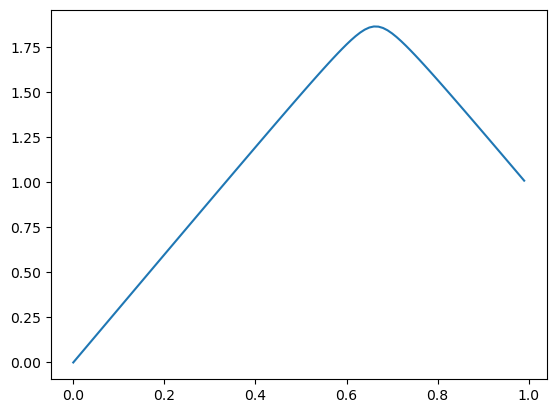

In [29]:
plt.plot(lmbs/n_points, energies)
# save_fig('qk-1qb.pdf')
plt.show()

With **src.base**
$$
H = H_0 + \lambda H_I = \left( \mathcal{E} + \lambda c \right) I + (\Omega + \lambda \omega_z)\sigma_z + (\lambda \omega_x)\sigma_x
$$

In [30]:

def my_ansatz(params):
    '''params: list of parameters for the ansatz, [theta, phi]'''
    qc = Qubit()
    qc.rx(params[0], 0)
    qc.ry(params[1], 0)
    return qc

def my_H(lmb):
    # computes the hamiltonian
    return pauli_sum([('X', lmb*omega_x), 
                      ('Z', Omega+lmb*omega_z), 
                      ('I', lmb*c+epsilon)])

def expectation(qc, lmb, n_shots=10000):

    coeffs = {'X': lmb*omega_x, 
            'Z': Omega+lmb*omega_z, 
            'I': lmb*c+epsilon}
    
    qc_copy = qc.copy()
    qc_copy.hadamard(0)
    count_x = qc_copy.measure(n_shots)[:, 0]

    qc_copy = qc.copy()
    count_z = qc_copy.measure(n_shots)[:, 0]

    expt = 0
    count_x *= coeffs['X']
    count_z *= coeffs['Z']

    expt += count_x[0]
    expt -= count_x[1]
    
    expt += count_z[0]
    expt -= count_z[1]

    return coeffs['I'] + expt / n_shots

qc = Qubit()
expectation(qc, 0.5)

1.50026

In [31]:
a = my_ansatz((np.pi/2,np.pi/2))
a

Qubit(s) in state: 
 0.50+0.50j|0⟩ + 0.50-0.50j|1⟩ 

In [32]:
from algorithms import Vqe 

In [39]:
n_points = 100

init_points = np.random.uniform(low=-np.pi, high=np.pi, size=2)
my_vqe = Vqe(my_ansatz, init_points, expectation=expectation)

my_energies = np.zeros(n_points)
lmbs = np.arange(n_points)
for i, lmb in enumerate(lmbs):
    lmb = lmb / n_points
    my_ham = my_H(lmb)
    min_params, min_energy = my_vqe.minimise_eigenvalue(my_ham, lmb)
    # print(f"lambda: {lmb}, energy: {min_energy}")
    my_energies[i] = min_energy



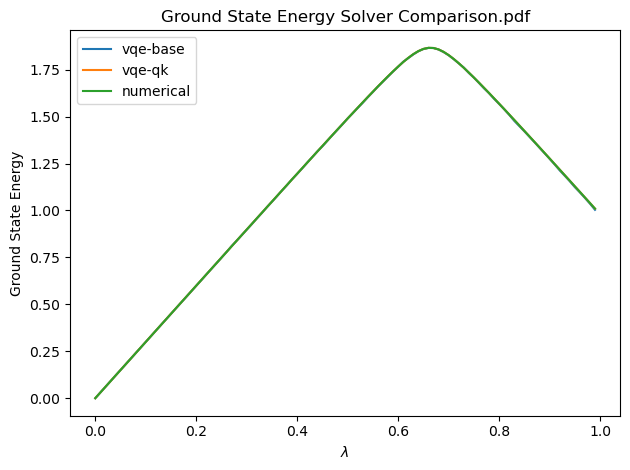

In [36]:
plot_2D(lmbs/n_points, [my_energies, energies, eigs[1]], plot_count=3, label=['vqe-base', 'vqe-qk', 'numerical'],
        x_title=r'$\lambda$', y_title='Ground State Energy', title='Ground State Energy Solver Comparison.pdf',)
        # filename='1qb-al.pdf')